# Problem 9.16

**Fundamentals of Solar Cells and Photovoltaic Systems Engineering**

**Solutions Manual - Chapter 9**

**Problem 9.16**


**In this problem you are asked to evaluate the impact of the PV generator capacity on the self-consumption ratio (SCR) and self-sufficiency ratio (SSR) for a distributed PV system supplying a household demand. The tabulated demand data is provided in this book’s online repository. Use pvlib and the Typical Meteorological Year (TYM) and assume that the system is installed in Munich, Germany (48.1371$^{\circ}$N, 11.5761$^{\circ}$E). The PV panels are oriented toward the south with an inclination angle $\beta=30^{\circ}$.** 

**Assume that the power production every hour is proportional to the irradiance on the plane of the array (POA); that is, we neglect the impact of the cell temperature on the efficiency. Assume also that capture losses and system losses are constant in time and equal to 5% and 6%, respectively.**


We will use the packages [pvlib](https://pvlib-python.readthedocs.io/en/stable/), [pandas](https://pandas.pydata.org/) and [matplotlib.pyplot](https://matplotlib.org/stable/index.html) to plot the results. We will also use the package [pytz](https://pypi.org/project/pytz/) to determine the time zone of Germany.

In [1]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import numpy as np

We start by defining the location, date, and time. We also define the orientation and tilt angles.

In [2]:
# Munich, Germany
lat, lon =  48.1371, 11.5761

tz = pytz.country_timezones('DE')[0] # timezone corresponding to country 'DE' (Germany)

# location
location = pvlib.location.Location(lat, lon, tz=tz)

orientation = 180 # pvlib sets orientation origin at North -> South=180
tilt = 30

We retrieve typical meteorological year (TMY) data from PVGIS.

In [3]:
tmy, _, _, _ = pvlib.iotools.get_pvgis_tmy(latitude=lat, longitude=lon, map_variables=True)

tmy.index = tmy.index.tz_convert(tz) # use local time

We calculate the Sun's coordinates and the irradiance on the plane of array (POA).

In [4]:
# calculate Sun's coordinates
solar_position = location.get_solarposition(times=tmy.index)

# calculate irradiante at the plane of the array (poa)
poa_irradiance = pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,
                                                       surface_azimuth=orientation,
                                                       dni=tmy['dni'],
                                                       ghi=tmy['ghi'],
                                                       dhi=tmy['dhi'],
                                                       solar_zenith=solar_position['apparent_zenith'],
                                                       solar_azimuth=solar_position['azimuth'])

We retrieve the load profile corresponding to residential appartment 5 included in the household dataset provided at the [Open Power System Data Platform](https://data.open-power-system-data.org/household_data/2020-04-15)

In [5]:
data=pd.read_csv('data/household_data_60min_singleindex_filtered.csv', index_col=0)
data.index = pd.to_datetime(data.index)
date = '2018-01-01'
times = pd.date_range(start=date, freq='1H', periods=8760, tz='UTC')
total_load=data.loc[times,'DE_KN_residential5_grid_import'] #cumulative load, kWh
load=total_load.diff().dropna()

We can plot the average hourly demand to get an idea of the profile. 

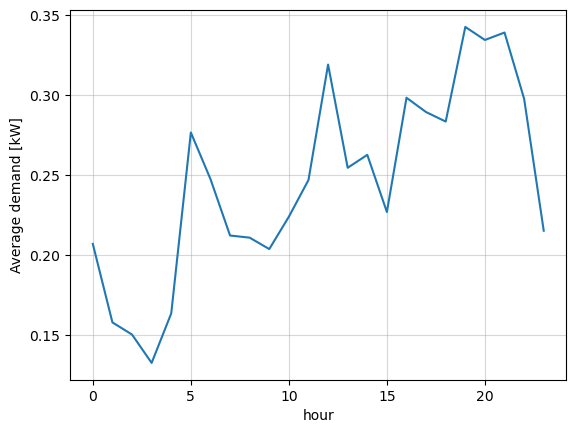

In [6]:
plt.figure()
plt.plot(load.groupby(load.index.hour).mean())
plt.grid(alpha=0.5)
plt.xlabel('hour')
plt.ylabel('Average demand [kW]')
plt.show()

For different ratios $r$ (PV system generation to load consumption), we calculate the self-consumption ratio (SCR) and the self-sufficiency ratio (SSR) . 

In [7]:
L_C = 0.05 # capture losses
L_S = 0.06 # system losses
annual_pv_generation = (1-L_C)*(1-L_S)*poa_irradiance['poa_global'].sum()*0.001 
annual_demand = load.sum()
PV_capacity_ref = annual_demand/annual_pv_generation # PV capacity needed to make PV generation=demand

ratios=0.1*np.arange(1,41)
SCR=pd.Series(index=ratios, dtype='float')
SSR=pd.Series(index=ratios, dtype='float')

for r in ratios:
    pv_generation = r*PV_capacity_ref*(1-L_C)*(1-L_S)*poa_irradiance['poa_global']*0.001
    self_consumption = [load[h] if load[h]<pv_generation[h] else pv_generation[h] for h in np.arange(0,8759)]
    SCR[r] = 100*sum(self_consumption)/pv_generation.sum()
    SSR[r] = 100*sum(self_consumption)/load.sum()

(0.0, 100.0)

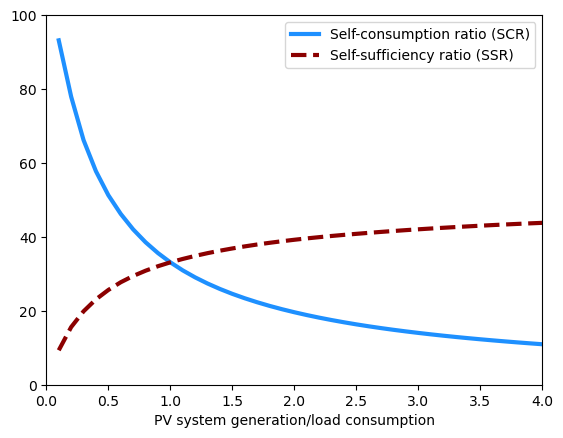

In [8]:
SCR.plot(color='dodgerblue', label='Self-consumption ratio (SCR)', linewidth=3)
SSR.plot(color='darkred', label='Self-sufficiency ratio (SSR)', linewidth=3, linestyle='dashed')
plt.xlabel('PV system generation/load consumption')
plt.legend()
plt.xlim([0,4])
plt.ylim([0,100])